Fraud Card Transaction

card_transdata.csv dataset has 1,000,000 rows and 8 columns:
https://www.kaggle.com/datasets/dhanushnarayananr/credit-card-fraud/data


In [3]:
#packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, auc, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import IsolationForest

In [4]:
#brief analysis
df = pd.read_csv("card_transdata.csv")

dfcorrs = df.corr()
dfcorrs["fraud"]

,fraud
distance_from_home,0.186070
distance_from_last_transaction,0.097665
ratio_to_median_purchase_price,0.454783
repeat_retailer,-0.002552
used_chip,-0.062513
used_pin_number,-0.100647
online_order,0.192185
fraud,1.000000


/tmp/ipython-input-1675129750.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


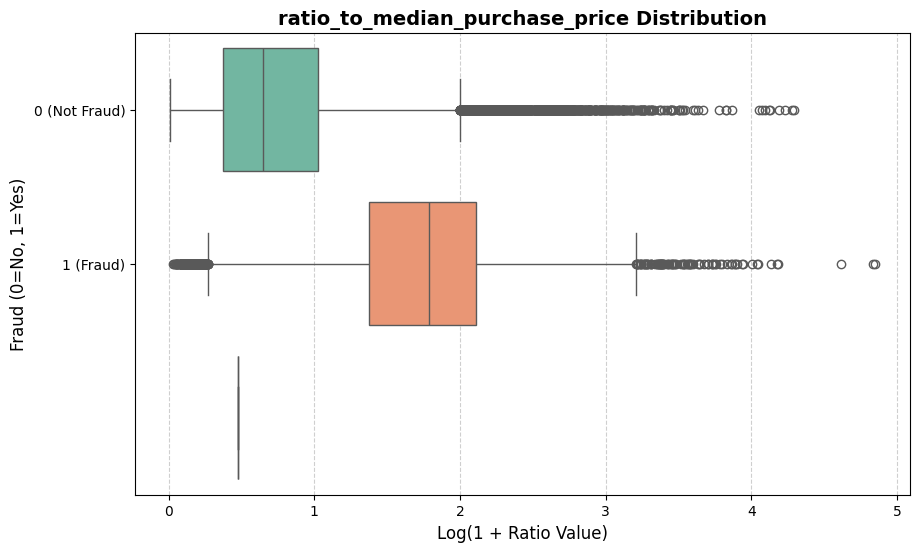

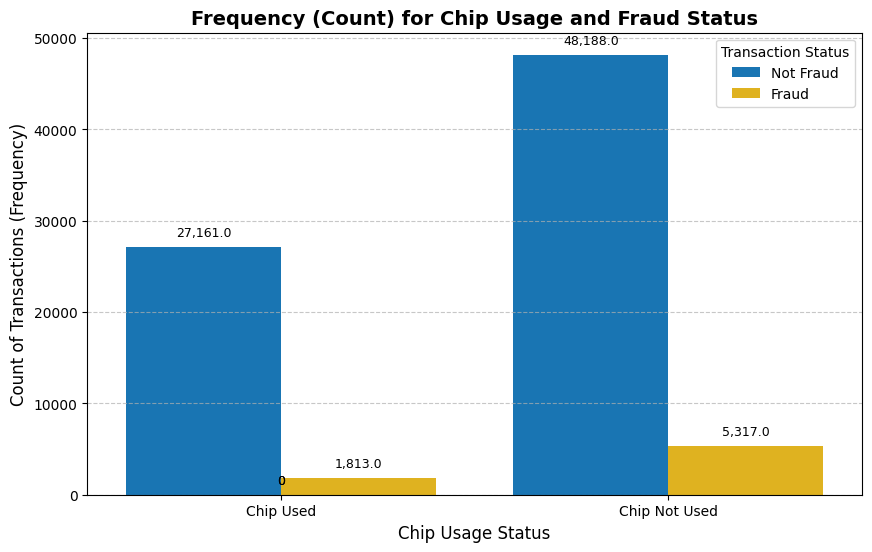

In [5]:
#EDA
feature = 'ratio_to_median_purchase_price'
df['Log_Ratio'] = np.log1p(df[feature])

plt.figure(figsize=(10, 6))

sns.boxplot(
    x=df['Log_Ratio'],
    y=df['fraud'].astype(str),
    orient='h',
    palette='Set2'
)

title = feature.replace("_", " ").title()
plt.title('ratio_to_median_purchase_price Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Log(1 + Ratio Value)', fontsize=12)
plt.ylabel('Fraud (0=No, 1=Yes)', fontsize=12)
plt.yticks([0, 1], ['0 (Not Fraud)', '1 (Fraud)'])
plt.grid(axis='x', linestyle='--', alpha=0.6)


#bar graph used chip
df['Used_Chip_Label'] = df['used_chip'].map({0.0: 'Chip Not Used', 1.0: 'Chip Used'})
df['Fraud_Label'] = df['fraud'].map({0.0: 'Not Fraud', 1.0: 'Fraud'})
plt.figure(figsize=(10, 6))

sns.countplot(
    x='Used_Chip_Label',
    hue='Fraud_Label',
    data=df,
    palette=['#007ACC', '#FFC300']
)

plt.title('Frequency (Count) for Chip Usage and Fraud Status', fontsize=14, fontweight='bold')
plt.xlabel('Chip Usage Status', fontsize=12)
plt.ylabel('Count of Transactions (Frequency)', fontsize=12)
plt.legend(title='Transaction Status', loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

ax = plt.gca()
for p in ax.patches:
    ax.annotate(f'{p.get_height():,}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 10),
                textcoords='offset points',
                fontsize=9)

In [8]:
df = df.dropna()
# Define feature columns explicitly (exclude engineered/display columns)
df.drop_duplicates(inplace=True)

train_df, test_df = train_test_split(df,
                                     train_size=0.8,
                                     random_state=42,
                                     stratify=df['fraud'])

contCol = ['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']
binaryCol = ['repeat_retailer', 'used_chip', 'used_pin_number', 'online_order']
feature_cols = contCol + binaryCol

# Select only the feature columns for X to avoid non-feature columns like Log_Ratio, Used_Chip_Label, Fraud_Label
X_train = train_df[feature_cols]
y_train = train_df['fraud']
X_test = test_df[feature_cols]
y_test = test_df['fraud']

s = StandardScaler()
X_train_scaled_cont = s.fit_transform(X_train[contCol])
X_test_scaled_cont = s.transform(X_test[contCol])

X_train_scaled = pd.DataFrame(X_train_scaled_cont, columns=contCol, index=X_train.index)
# assign binary columns (use values to avoid index alignment surprises)
X_train_scaled[binaryCol] = X_train[binaryCol].values
# ensure consistent column order
X_train_scaled = X_train_scaled[feature_cols]

X_test_scaled = pd.DataFrame(X_test_scaled_cont, columns=contCol, index=X_test.index)
X_test_scaled[binaryCol] = X_test[binaryCol].values
X_test_scaled = X_test_scaled[feature_cols]

#model training
lr = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
lr.fit(X_train_scaled, y_train)

svc = SVC(kernel='linear', random_state=42, class_weight='balanced', max_iter=2000, probability=True)
svc.fit(X_train_scaled, y_train)

yLr = lr.predict(X_test_scaled)
print("\nLogistic Regression:")
print(classification_report(y_test, yLr, target_names=['Not Fraud (0)', 'Fraud (1)']))

ySvc = svc.predict(X_test_scaled)
print("\nSVM (SVC):")
print(classification_report(y_test, ySvc, target_names=['Not Fraud (0)', 'Fraud (1)']))

/tmp/ipython-input-3806757355.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(inplace=True)
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(



Logistic Regression:
               precision    recall  f1-score   support

Not Fraud (0)       1.00      0.93      0.96     15070
    Fraud (1)       0.57      0.95      0.71      1426

     accuracy                           0.93     16496
    macro avg       0.78      0.94      0.84     16496
 weighted avg       0.96      0.93      0.94     16496


SVM (SVC):
               precision    recall  f1-score   support

Not Fraud (0)       1.00      0.20      0.33     15070
    Fraud (1)       0.11      1.00      0.19      1426

     accuracy                           0.27     16496
    macro avg       0.55      0.60      0.26     16496
 weighted avg       0.92      0.27      0.32     16496



Results of the SVC:
 TN: 3011,
 FP: 12059,
 FN: 4,
 TP: 1422
Results of Logistic Regression:
 TN: 14051,
 FP: 1019,
 FN: 70,
 TP: 1356


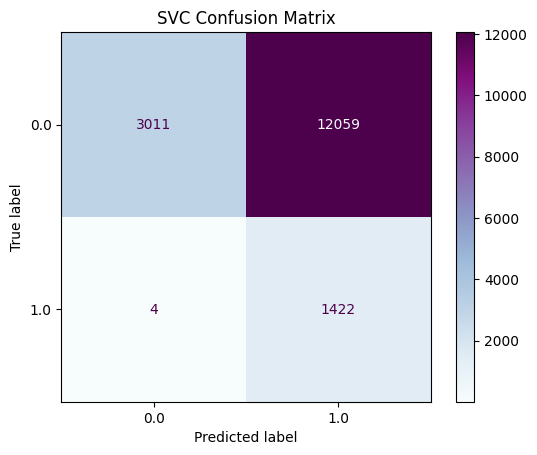

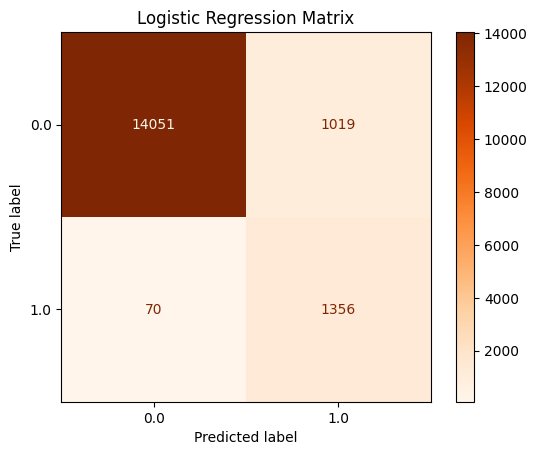

In [9]:
#confusion matrixs
ConfusionMatrixDisplay.from_predictions(y_test, ySvc, cmap  = "BuPu")
plt.title("SVC Confusion Matrix")
ConfusionMatrixDisplay.from_predictions(y_test, yLr, cmap = "Oranges")
plt.title("Logistic Regression Matrix")

#results
tn, fp, fn, tp = confusion_matrix(y_test, ySvc).ravel()
print(f"Results of the SVC:\n TN: {tn},\n FP: {fp},\n FN: {fn},\n TP: {tp}")
tn, fp, fn, tp = confusion_matrix(y_test, yLr).ravel()
print(f"Results of Logistic Regression:\n TN: {tn},\n FP: {fp},\n FN: {fn},\n TP: {tp}")


Decision Tree:
               precision    recall  f1-score   support

Not Fraud (0)       1.00      1.00      1.00     15070
    Fraud (1)       1.00      1.00      1.00      1426

     accuracy                           1.00     16496
    macro avg       1.00      1.00      1.00     16496
 weighted avg       1.00      1.00      1.00     16496


Random Forest:
               precision    recall  f1-score   support

Not Fraud (0)       1.00      1.00      1.00     15070
    Fraud (1)       1.00      1.00      1.00      1426

     accuracy                           1.00     16496
    macro avg       1.00      1.00      1.00     16496
 weighted avg       1.00      1.00      1.00     16496



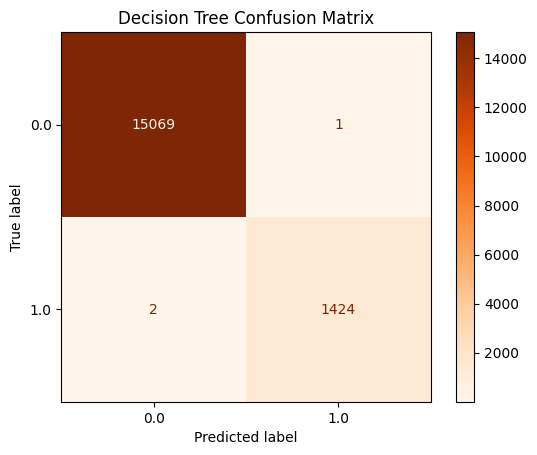

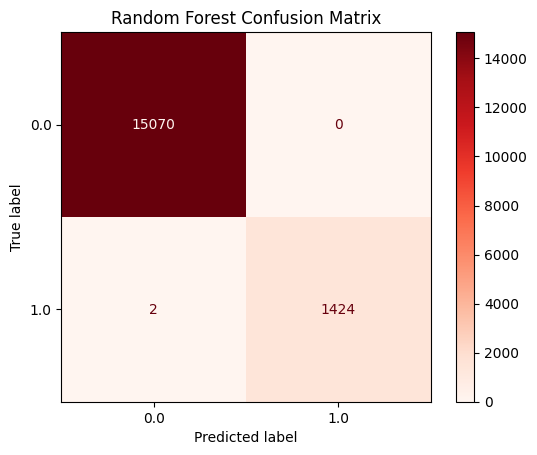

Results of Decision Tree:
 TN: 15069,
 FP: 1,
 FN: 2,
 TP: 1424
Results of Random Forest:
 TN: 15070,
 FP: 0,
 FN: 2,
 TP: 1424


<Figure size 640x480 with 0 Axes>


Area Under the Curve (AUC) Scores
Logistic Regression AUC: 0.9802
SVM (SVC) AUC: 0.8627
Decision Tree AUC: 0.9993
Random Forest AUC: 1.0000


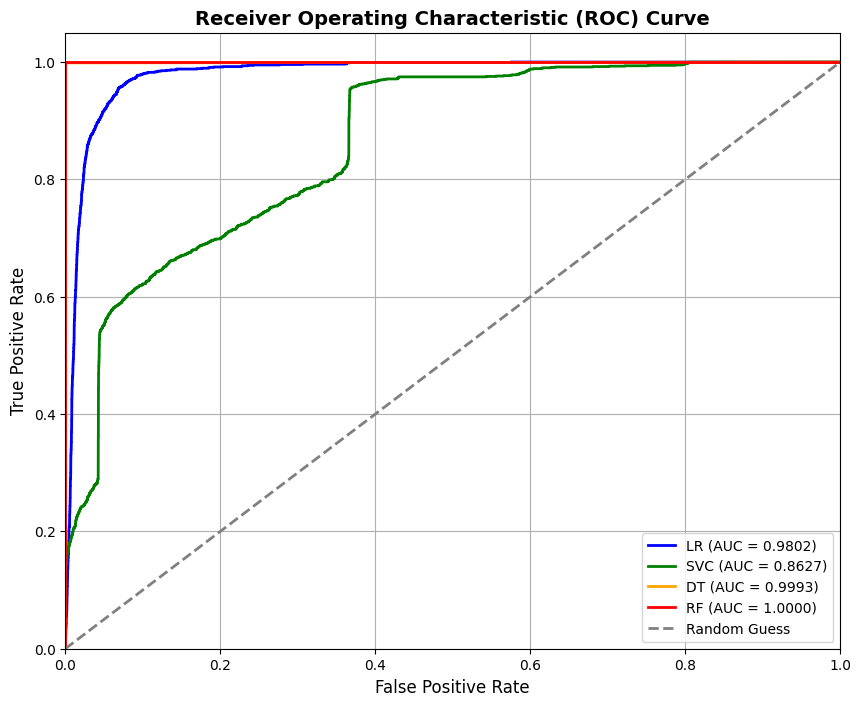

In [10]:
# Decision Tree and Random Forest
dt = DecisionTreeClassifier(random_state=42, class_weight='balanced')
dt.fit(X_train_scaled, y_train)

rf = RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=100)
rf.fit(X_train_scaled, y_train)

yDt = dt.predict(X_test_scaled)
yRf = rf.predict(X_test_scaled)

# Classification Reports for dt and rf
print("\n" + "="*50)
print("Decision Tree:")
print(classification_report(y_test, yDt, target_names=['Not Fraud (0)', 'Fraud (1)']))

print("\nRandom Forest:")
print(classification_report(y_test, yRf, target_names=['Not Fraud (0)', 'Fraud (1)']))

#confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, yDt, cmap="Oranges")
plt.title("Decision Tree Confusion Matrix")
plt.show()

ConfusionMatrixDisplay.from_predictions(y_test, yRf, cmap="Reds")
plt.title("Random Forest Confusion Matrix")
plt.show()

#results
tn, fp, fn, tp = confusion_matrix(y_test, yDt).ravel()
print(f"Results of Decision Tree:\n TN: {tn},\n FP: {fp},\n FN: {fn},\n TP: {tp}")

tn, fp, fn, tp = confusion_matrix(y_test, yRf).ravel()
print(f"Results of Random Forest:\n TN: {tn},\n FP: {fp},\n FN: {fn},\n TP: {tp}")


plt.suptitle('Comparison of Decision Tree and Random Forest Confusion Matrices', fontsize=16, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()

# ROC and AUC
yLr_prob = lr.predict_proba(X_test_scaled)[:, 1]
ySvc_prob = svc.decision_function(X_test_scaled)
yDt_prob = dt.predict_proba(X_test_scaled)[:, 1]
yRf_prob = rf.predict_proba(X_test_scaled)[:, 1]

auc_lr = roc_auc_score(y_test, yLr_prob)
auc_svc = roc_auc_score(y_test, ySvc_prob)
auc_dt = roc_auc_score(y_test, yDt_prob)
auc_rf = roc_auc_score(y_test, yRf_prob)

fpr_lr, tpr_lr, _ = roc_curve(y_test, yLr_prob)
fpr_svc, tpr_svc, _ = roc_curve(y_test, ySvc_prob)
fpr_dt, tpr_dt, _ = roc_curve(y_test, yDt_prob)
fpr_rf, tpr_rf, _ = roc_curve(y_test, yRf_prob)

print("\n" + "="*50)
print("Area Under the Curve (AUC) Scores")
print("="*50)
print(f"Logistic Regression AUC: {auc_lr:.4f}")
print(f"SVM (SVC) AUC: {auc_svc:.4f}")
print(f"Decision Tree AUC: {auc_dt:.4f}")
print(f"Random Forest AUC: {auc_rf:.4f}")

plt.figure(figsize=(10, 8))
plt.plot(fpr_lr, tpr_lr, color='blue', lw=2, label=f'LR (AUC = {auc_lr:.4f})')
plt.plot(fpr_svc, tpr_svc, color='green', lw=2, label=f'SVC (AUC = {auc_svc:.4f})')
plt.plot(fpr_dt, tpr_dt, color='orange', lw=2, label=f'DT (AUC = {auc_dt:.4f})')
plt.plot(fpr_rf, tpr_rf, color='red', lw=2, label=f'RF (AUC = {auc_rf:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(True)
plt.show()

In [30]:
df.head()
#the input could be filled with automated data
input = pd.DataFrame([[1000, 965, 1.5, 1, 0, 1, 1]])
#far from home and online, should be flagged.
answer = rf.predict(input)

if answer == 1:
  print("Fraud!")
else:
  print("Not Fraud")


Fraud!


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
